Obtaining smaple points for time-fee equation ...
Number of steps: 50000
Number of steps: 100000
************************** Linear regression****************************
Time-fee equation is: f(t) = 0.072180 * t + 1.132566
************************** Curve regression****************************
Time-fee equation is: y(x) = 2.492318 * ln( t^(1.327729) + 63.921420) + -9.213203


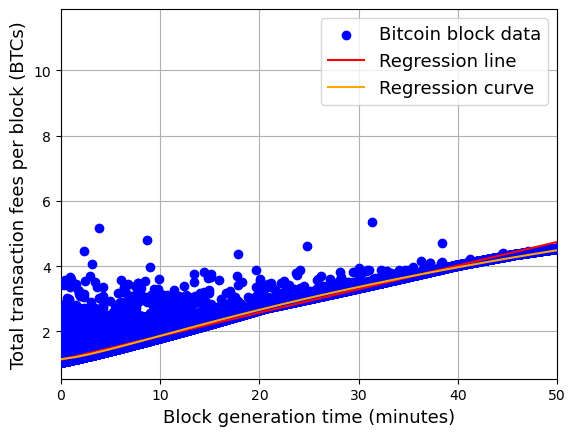

Obtaining the normal adversarial block reward per minute while mining honestly ...
Normal adversarial block reward per minute 0.08327665429732464
Obtaining the average fee ratio of 30-minute and 20-minute blocks to a 10-minute block ...
Average 10-min block fee: 1.8547298889436368
Average 20-min block fee: 2.7420216053781896
Average 30-min block fee: 3.488659830648281
Average ratio of a 20-min block to a 10-min block: 1.4783940355540994
Average ratio of a 30-min block to a 10-min block: 1.8809530441304585
Obtaining an MDP-based lower bound for selfish mining profitability before difficulty adjustment ...
numOfStates: 314880
processing state: 0
processing state: 100000
processing state: 200000
processing state: 300000
A lower bound for selfish mining profitability ratio before difficulty adjustment 1.2621925074879057
A3C trining is starting ...
A3C_args: {'lr': 1e-06, 'gamma': 0.99, 'gae_lambda': 0.99, 'entropy_coef': 0.01, 'value_loss_coef': 0.5, 'max_grad_norm': 50, 'noise_std': 0.2, 


KeyboardInterrupt



In [2]:
#Code adapted from "https://github.com/ikostrikov/pytorch-a3c" and "https://github.com/dgriff777/a3c_continuous" 
import os
import torch
import torch.multiprocessing as mp
from torch.multiprocessing import Pool
import my_optim
from model import ActorCritic
from test import test
from train import train
import easydict
from mempool_analyzer import Mempool_data
from normal_reward import Honest_mining_block_reward
from fee_30_20_10_ratio import fee_ratio
from lower_bound_profits import lower_bound_selfish_mining_profitability
from time_fee_equation import time_fee

A3C_args = easydict.EasyDict({
        "lr": 0.000001,
        "gamma": 0.99,
        "gae_lambda": 0.99,
        "entropy_coef": 0.01,
        "value_loss_coef": 0.5,
        "max_grad_norm": 50,
        "noise_std": 0.2,
        "reward_scaling_coefficient": 0.1,
        "N_nodes_per_layer": 256,
        "seed": 1,
        "num_processes_train": 30,
        "num_processes_test": 2,
        "num_steps": 10,
        "testing_episode_length": 100000,
        "training_print_length": 1000,
        "max_episode_length": 1000000,
        "env_name": 'Blockchain',
        "long_range_testing": False,
        "testing_index": 0,
        "no_shared": False
    })

BTC_args = easydict.EasyDict({
        "adversarial_ratio": 0.45,
        "rational_ratio": 0,
        "connectivity": 1,
        "max_fork": 20, 
        "len_abort": 1,
        "mining_time": 10,
        "block_fixed_reward": 0, 
        "max_block_size": 1,
        "attack_type": 1,  # 0: selfish_mining_undercutting, 1: selfish_mining, 2: undercutting
        "noise": False,
        "epsilon": 0,
        "Diff_adjusted": False, # False: before difficulty adjustment, True: after difficulty adjustment
        "state_length": None,
        "n_action": None
    })

# Mempool statistics are obtained by analyzing the data available on https://jochen-hoenicke.de/queue/#BTC,24h,weight
# Mempool statistics for range: from 18/12/2023_23_00_00 to 18/12/2023_23_59_59
Mempool_args = easydict.EasyDict({
        "start_date_str": '18/12/2023_23_00_00',
        "end_date_str": '18/12/2023_23_59_59',
        "N_memPool_section": 10,
        "sat_per_byte_range_length": 50,
        "N_steps_honest_mining": 100000,
        "Base_sat_per_byte_range": 80,
        "coefficient_mempool_reward": [[0.14820472025394815, 0.7282113495520344, 5.643656907094102e-13], [0.028176438487433484, 0.9737897315715454, 2.3789063131700735e-15], [0.0031013597177395715, 1.0425169856310426, 0.001258925715929511], [0.0015461140408195586, 1.2052345863085565, 0.00134868764746486], [0.00031051785879065904, 1.6901314778574512, 0.0011832712576748628], [0.0005666599801514915, 1.0342370769473448, 0.0002195612705050585], [0.0009569976216924068, 0.9847738342913699, 0.00013723654148004898], [0.0012181085040403486, 0.9680190302600027, 8.24182077841877e-05], [0.0011097634762145296, 1.2298617957556142, 0.00034394872578617547], [0.006865268297209494, 1.0648883461564944, 0.0015278300081780468]],
        "fee_twenty_ten_ratio": None,
        "fee_thirty_ten_ratio": None,
        "normal_adversarial_block_reward_per_min": None,
        "noise_std_mempool_reward": None
    })

# Mempool statistics for range: from 6/9/2024_8_00_00 to 6/9/2024_8_59_59
# Mempool_args = easydict.EasyDict({
#         "start_date_str": '6/9/2024_8_00_00',
#         "end_date_str": '6/9/2024_8_59_59',
#         "N_memPool_section": 10,
#         "sat_per_byte_range_length": 1,
#         "N_steps_honest_mining": 100000,
#         "coefficient_mempool_reward": [[0.055806873308782215, 0.38072178794547107, 1.595299419478695e-14], [0.021693107288395685, 0.6800462872806099, 0.04374277956444347], [0.024167414548314777, 0.8044262036320328, 3.7726809116912525e-20], [0.024452552476114324, 0.7831778010712924, 6.142812348160881e-16], [0.0004273199223943512, 1.7661094945688913, 0.004719795490864381], [2.175811997791172e-05, 2.2668297629100285, 0.0045860815832734145], [0.0004564992915334651, 1.3613028638664004, 0.0013761469651945573], [0.0004564992915334651, 1.3613028638664004, 0.0013761469651945573], [4.0618094859605475e-07, 3.4100103962391883, 0.0019188736640224694], [0.0005581315530157322, 1.6358162269055594, 0.012445199605116525]],
#         "Base_sat_per_byte_range": 2,
#         "fee_twenty_ten_ratio": None,
#         "fee_thirty_ten_ratio": None,
#         "normal_adversarial_block_reward_per_min": None,
#         "noise_std_mempool_reward": None
#     })

# Mempool statistics for range: from 15/10/2023_8_00_00 to 15/10/2023_8_59_59
# Mempool_args = easydict.EasyDict({
#         "start_date_str": '15/10/2023_8_00_00',
#         "end_date_str": '15/10/2023_8_59_59',
#         "N_memPool_section": 10,
#         "sat_per_byte_range_length": 1,
#         "N_steps_honest_mining": 100000,
#         "coefficient_mempool_reward": [[0.06592696644240723, 0.9213874131703799, 0.05589698973317477], [0.03215894190329676, 0.6237651789702087, 7.77328093837064e-12], [0.01703337274000704, 0.8312690283643408, 2.383520093265834e-16], [0.005023481905600935, 0.8622179583493358, 1.045809783118055e-14], [0.0020465327541133, 0.7346101245070619, 2.0290183142002714e-13], [0.000745904081654545, 0.7860338241302187, 2.332220701952698e-16], [0.0009694665405339612, 0.8846388803371542, 1.9702843186863277e-10], [6.3980591818408935e-06, 2.6370934257885517, 0.001972280378113425], [6.3980591818408935e-06, 2.6370934257885517, 0.001972280378113425], [0.010759845969409917, 1.3062356069124947, 0.012778063200197348]],
#         "Base_sat_per_byte_range": 1,
#         "fee_twenty_ten_ratio": None,
#         "fee_thirty_ten_ratio": None,
#         "normal_adversarial_block_reward_per_min": None,
#         "noise_std_mempool_reward": None
#     })


# def change_parameters():
#     global Mempool_args
#     Mempool_args.sat_per_byte_range_length = float(input("Enter new value for Mempool_args['sat_per_byte_range_length']: "))

def mempool_main():
    mempool = Mempool_data(Mempool_args)
    coefficient, noise_std, base_sat_per_byte = mempool.extract_mempool_data()
    # Prompting the user for input
    user_input = input("Enter 'c' to continue or 's' to stop and change mempool parameters: ").strip().lower()
    if user_input == 's':
        change_parameters()
        mempool_main()
    elif user_input == 'c':
        print("Continuing with the code...")
    else:
        print("Invalid input. Exiting the code.")
    return coefficient, noise_std, base_sat_per_byte

os.environ['OMP_NUM_THREADS'] = '1'
if __name__ == '__main__':
    BTC_args.state_length = 5 + 2 * BTC_args.max_fork + Mempool_args.N_memPool_section + 2 * (BTC_args.max_fork * Mempool_args.N_memPool_section)
    BTC_args.n_action = 6 + BTC_args.len_abort
    time_fee(BTC_args, Mempool_args)
    Mempool_args.normal_adversarial_block_reward_per_min = Honest_mining_block_reward(BTC_args, Mempool_args)
    Mempool_args.fee_twenty_ten_ratio, Mempool_args.fee_thirty_ten_ratio = fee_ratio(BTC_args, Mempool_args)
    profit_before_difficulty_adjustment = lower_bound_selfish_mining_profitability(BTC_args, Mempool_args)
    print("A lower bound for selfish mining profitability ratio before difficulty adjustment", profit_before_difficulty_adjustment / BTC_args.adversarial_ratio)
    print("A3C trining is starting ...")
    print("A3C_args:", A3C_args)
    print("BTC_args", BTC_args)
    print("Mempool_args", Mempool_args)
    mp.set_start_method('spawn', force=True)
    torch.manual_seed(A3C_args.seed)
    shared_model_a = ActorCritic(A3C_args, BTC_args)
    shared_model_a.share_memory()

    if A3C_args.no_shared:
        optimizer_a = None
    else:
        optimizer_a = my_optim.SharedAdam(shared_model_a.parameters(), lr=A3C_args.lr)
        optimizer_a.share_memory()

    processes = []
    manager = mp.Manager()
    counter = manager.Value('i', 0)
    profit_ratio_max = manager.Value('d', 1)
    lock = manager.Lock()
    N_train_agents = A3C_args.num_processes_train if not A3C_args.long_range_testing else 0
    args_list_train = [(rank, A3C_args, BTC_args, Mempool_args, shared_model_a, optimizer_a, counter, profit_ratio_max, lock) for rank in range(N_train_agents)]
    args_list_test = [(rank, A3C_args, BTC_args, Mempool_args, shared_model_a, counter, profit_ratio_max) for rank in range(A3C_args.num_processes_test)]
    with Pool(A3C_args.num_processes_train + A3C_args.num_processes_test) as pool:
        p1, p2 = pool.starmap_async(test, args_list_test), pool.starmap_async(train, args_list_train)
        p1.get()
        p2.get()
